# Recreating and Enhancing GC-MERGE to Predict Gene Expression with Long-Range Genomic Interactions

GC-MERGE is a graph convolutional network model developed in recent years that incorporates both Hi-C data and CHIP-seq data to predict gene expression (<a href="https://pmc.ncbi.nlm.nih.gov/articles/PMC9125570/">Bigness et al., 2022</a>). In this notebook, we will recreate figure 3 in the paper and compare GC-MERGE to baseline models.

In [1]:
data_path = 'data/'

In [2]:
import sys
sys.argv = ['']

In [27]:
import numpy as np
import pandas as pd
import os
import pickle

import torch
import torch.nn as nn
import torch_geometric
import torch.optim as optim
import torch.nn.functional as F

import argparse
import time
from datetime import datetime, date
import random

from scipy.sparse import load_npz
from scipy.stats import pearsonr
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

import matplotlib.pyplot as plt

In [4]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
import model_classes_
# import process_inputs_
import run_models_
import sage_conv_cat_

run_models_.py
Model date and time:
2024-10-29-at-13-41-56 


Cell line: E122
Task: Regression
ChIP-seq resolution: 10000


Training set: 70%
Validation set: 15%
Testing set: 15%


Model hyperparameters: 
Number of epochs: 1000
Learning rate: 0.0001
Number of graph convolutional layers: 2
Graph convolutional embedding size: 256
Number of linear layers: 3
Linear hidden layer size: 256

Model's state_dict:
conv1.lin_l.weight 	 torch.Size([256, 12])
conv1.lin_l.bias 	 torch.Size([256])
conv2.lin_l.weight 	 torch.Size([256, 512])
conv2.lin_l.bias 	 torch.Size([256])
lin1.weight 	 torch.Size([256, 256])
lin1.bias 	 torch.Size([256])
lin2.weight 	 torch.Size([256, 256])
lin2.bias 	 torch.Size([256])
lin3.weight 	 torch.Size([1, 256])
lin3.bias 	 torch.Size([1])


Epoch 0 out of 1000
Epoch 100 out of 1000
Epoch 200 out of 1000
Epoch 300 out of 1000
Epoch 400 out of 1000
Epoch 500 out of 1000
Epoch 600 out of 1000
Epoch 700 out of 1000
Epoch 800 out of 1000
Epoch 900 out of 1000
Elapsed time: 

## EDA

The data provided along with the paper includes CHIP-seq data of 6 histone markers, Hi-C data between genomic regions as an adjacency matrix, and prediction targets which are RNA-seq data from each genomic region. They are also provided separately for 3 cell lines: _GM12878_ (lymphoblastoid), _K562_ (myelogenous leukemia), and _HUVEC_ (human umbilical vein endothelial), respectively _E116_, _E122_, and _E123_ in terms of data storage. We will first conduct an exploratory data analysis on these data to understand them better.

In [50]:
cell_lines = ['E116', 'E122', 'E123']
cl_conversion_dct = {'E116': 'GM1287', 'E123': 'K562', 'E122': 'HUVEC'}

The first column of both CHIP-seq data and prediction targets are indices of genomic regions. The other columns are actual values for either histone markers or prediction targets.

E116
CHIP-seq shape: (279606, 7)
Classification target shape: (16699, 2)
Regression target shape: (16699, 2)


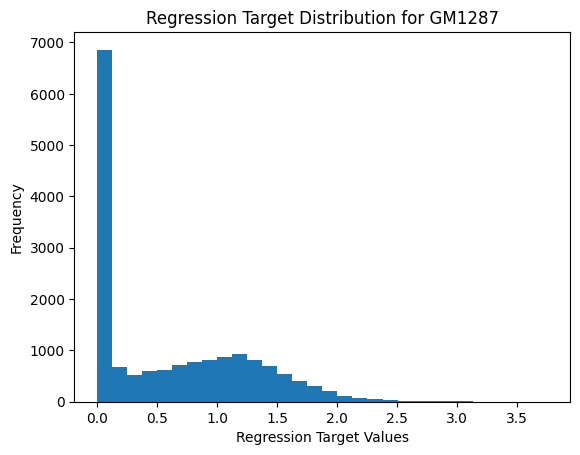

E122
CHIP-seq shape: (279598, 7)
Classification target shape: (16681, 2)
Regression target shape: (16681, 2)


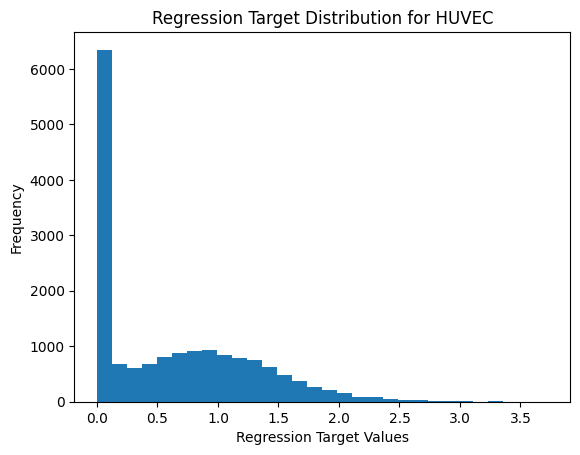

E123
CHIP-seq shape: (279601, 7)
Classification target shape: (16690, 2)
Regression target shape: (16690, 2)


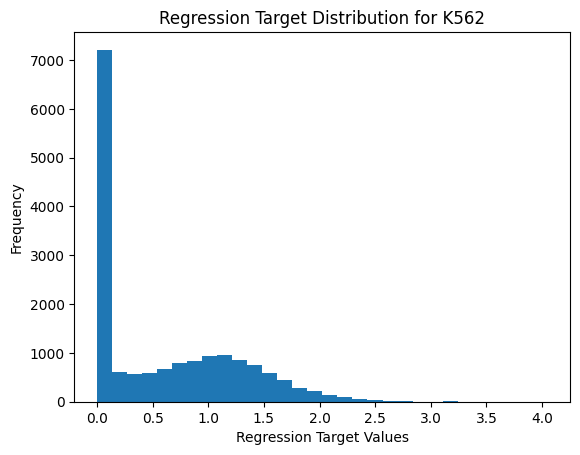

In [6]:
# CHIP-seq data & Target data (processed RNA-seq)
for cl in cell_lines:
    print(cl)
    
    # Load the CHIP-seq data
    chip_path = f"{data_path}{cl}/np_hmods_norm_chip_10000bp.npy"
    X = np.load(chip_path)
    print("CHIP-seq shape: " + str(X.shape))
    
    # Load the target data
    reg0_path = f"{data_path}{cl}/np_nodes_lab_genes_reg0.npy"
    reg0 = np.load(reg0_path)
    print("Classification target shape: " + str(reg0.shape))
    
    reg1_path = f"{data_path}{cl}/np_nodes_lab_genes_reg1.npy"
    reg1 = np.load(reg1_path)
    print("Regression target shape: " + str(reg1.shape))
    
    if cl == 'E123':
        sample_chip = X
        sample_reg = reg1
    
    # Plot the histogram
    plt.figure()  
    plt.hist(reg1[:,1], bins=30)  
    plt.title(f"Regression Target Distribution for {cl_conversion_dct[cl]}")
    plt.xlabel("Regression Target Values")
    plt.ylabel("Frequency")
    plt.show()  

In [7]:
sample_chip[:,0]

array([0.00000e+00, 1.00000e+00, 2.00000e+00, ..., 2.79598e+05,
       2.79599e+05, 2.79600e+05])

For each cell line, the Hi-C data is an adjacency matrix representing distances between genomic regions. It is very sparse, as most of genomic regions doesn't interact with each other. For example, the E123 (_HUVEC_) cell line have a Hi-C matrix with only $4.489 * 10^{-3}$% entries. Therefore, the Hi-C data are stored in sparse matrix format and have to be read and interpreted differently as normal matrices stored in arrays. 

In [8]:
# Hi-C data
for cl in cell_lines:
    print(cl)
    
    # Load the hi-c data
    hic_path = f"{data_path}{cl}/hic_sparse.npz"
    hic_data = np.load(hic_path)
    print("Hi-C shape: " + str(hic_data['shape']))
    
    if cl=='E123':
        sample_hic = hic_data['data']

E116
Hi-C shape: [279606 279606]
E122
Hi-C shape: [279598 279598]
E123
Hi-C shape: [279601 279601]


In [9]:
sample_hic

array([109.243022 ,  13.781856 , 101.689188 , ...,  79.7696375,
       132.6261   ,  51.782445 ])

In [10]:
sample_hic.shape

(3509064,)

In [11]:
3509064/(279601*279601)

4.488630420749498e-05

## GC-MERGE

The authors of the paper have already prepared the data and scripts to run the model, which are all stored in this <a href="https://github.com/rsinghlab/GC-MERGE">github repo</a>. For the purpose of this project, we've cloned this repo and use them directly to run the GC-MERGE model.

In [7]:
# run classifications and regressions on each cell line
for cl in cell_lines:
    for i in [0,1]:
        %run run_models_.py -c {cl} -rf {i}

run_models_.py
Model date and time:
2024-10-29-at-14-00-43 


Cell line: E116
Task: Classification
ChIP-seq resolution: 10000


Training set: 70%
Validation set: 15%
Testing set: 15%


Model hyperparameters: 
Number of epochs: 1000
Learning rate: 0.0001
Number of graph convolutional layers: 2
Graph convolutional embedding size: 256
Number of linear layers: 3
Linear hidden layer size: 256

Model's state_dict:
conv1.lin_l.weight 	 torch.Size([256, 12])
conv1.lin_l.bias 	 torch.Size([256])
conv2.lin_l.weight 	 torch.Size([256, 512])
conv2.lin_l.bias 	 torch.Size([256])
lin1.weight 	 torch.Size([256, 256])
lin1.bias 	 torch.Size([256])
lin2.weight 	 torch.Size([256, 256])
lin2.bias 	 torch.Size([256])
lin3.weight 	 torch.Size([2, 256])
lin3.bias 	 torch.Size([2])


Epoch 0 out of 1000
Epoch 100 out of 1000
Epoch 200 out of 1000
Epoch 300 out of 1000
Epoch 400 out of 1000
Epoch 500 out of 1000
Epoch 600 out of 1000
Epoch 700 out of 1000
Epoch 800 out of 1000
Epoch 900 out of 1000
Elapsed ti

#### Extract results

We've created two txt files to document the model performance on different tasks for the three cell lines. The metrics are also printed out as we run the model in the previous cell.

In [12]:
regression_results_meta = pd.read_csv('log_regression.txt')
regression_results_meta

,Cell line,Test pearson,File path
0,E116,0.765879,saved_runs/model_2024-10-29-at-14-04-30
1,E122,0.741837,saved_runs/model_2024-10-29-at-14-12-19
2,E123,0.816963,saved_runs/model_2024-10-29-at-14-19-38


In [13]:
classification_results_meta = pd.read_csv('log_classification.txt')
classification_results_meta

,Cell line,Test AUROC,Test AUPR,File path
0,E116,0.912144,0.889850,saved_runs/model_2024-10-29-at-14-00-43
1,E122,0.897573,0.870239,saved_runs/model_2024-10-29-at-14-08-48
2,E123,0.933665,0.912438,saved_runs/model_2024-10-29-at-14-16-05


Below we use a function to extract the true and predicted values for the test set from the stored regression results generated by the original script. We will visualize these results in the visualization part.

In [14]:
def extract_results(cl, fp):
    path = f'{data_path}{cl}/{fp}_test_metrics.npz'
    test_metric = np.load(path)
    y_true, y_pred = test_metric['test_labels'], test_metric['test_pred']
    return y_true, y_pred

gcn_results = {cl: {'y_true': [], 'y_pred': []} for cl in cell_lines}

for row in regression_results_meta.iterrows():
    cl, fp = row[1]['Cell line'], row[1]['File path']
    y_true, y_pred = extract_results(cl, fp)
    gcn_results[cl]['y_true'] = y_true
    gcn_results[cl]['y_pred'] = y_pred

In [17]:
gcn_results

{'E116': {'y_true': array([7.4816443e-02, 1.2221588e-01, 1.6026676e+00, ..., 8.6685643e-04,
         0.0000000e+00, 1.8273369e+00], dtype=float32),
  'y_pred': array([0.75512505, 1.2212895 , 0.5311072 , ..., 0.04765021, 0.05083667,
         1.1735519 ], dtype=float32)},
 'E122': {'y_true': array([0.39759243, 0.00216606, 0.        , ..., 0.        , 0.        ,
         0.5661386 ], dtype=float32),
  'y_pred': array([0.69241256, 0.2089414 , 0.0147909 , ..., 0.03534405, 0.0304466 ,
         1.4553151 ], dtype=float32)},
 'E123': {'y_true': array([1.6577536 , 0.87765944, 0.96736073, ..., 0.00302947, 1.339968  ,
         0.3170181 ], dtype=float32),
  'y_pred': array([1.3715566 , 1.096382  , 0.9502483 , ..., 0.38962704, 0.24517499,
         0.902174  ], dtype=float32)}}

In [18]:
gcn_results['E122']['y_true'].shape

(2503,)

## Baseline models

Below we've written a general data loading pipeline for the baseline models. It will mimic the data loading pipeline used by the authors of the paper, which shuffles the input data, splits it into training/validation/testing sets with proportions of 0.7/0.15/0.15.

In addition, since the authors only provided output expression level values/labels for a small proportion of target nodes, we are only using the data of these genomic regions for the baseline models. Our hypothesis of using these smaller number of regions as targets is that these are the genomic regions for which the researchers are able to obtain RNAseq data for.

In [19]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [20]:
def customize_extract_data(geneID, X, y):
    """
    This function extracts needed data by gene ID
    """
    x_mask = np.isin(X[:, 0], geneID)
    extracted_x = X[x_mask, 1:]
    
    y_mask = np.isin(y[:, 0], geneID)
    extracted_y = y[y_mask, 1]
    
    return extracted_x, extracted_y

In [21]:
def load_data(cl, reg_flag=1):
    """
    This function creates data loaders for specified cell lines.
    """
    npz_path_x = f"{data_path}{cl}/np_hmods_norm_chip_10000bp.npy"
    X = np.load(npz_path_x)
    if reg_flag == 1:
        npz_path_y = f"{data_path}{cl}/np_nodes_lab_genes_reg1.npy"
    else:
        npz_path_y = f"{data_path}{cl}/np_nodes_lab_genes_reg0.npy"
    data_y =  np.load(npz_path_y)
    
    X = torch.tensor(X, dtype= torch.float32)
    y = torch.tensor(data_y).float()
    X = X[data_y[:, :1].squeeze()]

    targetNode_mask = torch.tensor(data_y[:,0].astype(int)).long()
    pred_idx_shuff = torch.randperm(targetNode_mask.shape[0])

    fin_train = np.floor(0.7*pred_idx_shuff.shape[0]).astype(int)
    fin_valid = np.floor(0.85*pred_idx_shuff.shape[0]).astype(int)
    train_idx = pred_idx_shuff[:fin_train]
    valid_idx = pred_idx_shuff[fin_train:fin_valid]
    test_idx = pred_idx_shuff[fin_valid:]

    train_gene_ID = targetNode_mask[train_idx].numpy()
    valid_gene_ID = targetNode_mask[valid_idx].numpy()
    test_gene_ID = targetNode_mask[test_idx].numpy()
    
    X_train, y_train = customize_extract_data(train_gene_ID, X, y)
    X_val, y_val = customize_extract_data(valid_gene_ID, X, y)
    X_test, y_test = customize_extract_data(test_gene_ID, X, y)
    
    train_dataset = CustomDataset(X_train, y_train)
    val_dataset = CustomDataset(X_val, y_val)
    test_dataset = CustomDataset(X_test, y_test)
    
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

### MLP

To begin with, we implement a baseline Multilayer perceptron (MLP) with three fully connected layers similar to the one discussed in section 3.3 of the paper. We apply the ReLU activation function on each of the layers except the final output layer.

In [22]:
class MLPBaseline(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(MLPBaseline, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = nn.Linear(hidden_dim2, output_dim)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [25]:
def run_mlp_baseline(train_loader, val_loader, test_loader, input_dim, hidden_dim1, hidden_dim2, output_dim, lr=0.001, num_epochs=100):
    model = MLPBaseline(input_dim=input_dim, hidden_dim1 = hidden_dim1, hidden_dim2 = hidden_dim2, output_dim = output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        for data in train_loader:
            x, y = data
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output.squeeze(), y)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                x, y = data
                output = model(x)
                val_loss += criterion(output.squeeze(), y).item()
        if (epoch+1)%10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss/len(val_loader)}')

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in test_loader:
            x, y = data
            output = model(x)
            y_true.extend(y.numpy())
            y_pred.extend(output.squeeze().numpy())

    pcc = pearsonr(y_true, y_pred)[0]

    auroc = roc_auc_score((np.array(y_true) > np.median(y_true)).astype(int), y_pred)

    print(f'Test PCC: {pcc}')
    print(f'Test AUROC: {auroc}')
    return pcc, auroc, y_true, y_pred # store test predictions

In [28]:
mlp_metrics = pd.DataFrame(columns=['cell_line', 'pcc', 'auroc'])
mlp_results = {cl: {'y_true': [], 'y_pred': []} for cl in cell_lines}

for cl in cell_lines:
    print(cl)
    train_loader, val_loader, test_loader = load_data(cl)
    pcc, auroc, y_true, y_pred = run_mlp_baseline(train_loader, val_loader, test_loader, input_dim = 6 , hidden_dim1 = 4, hidden_dim2 = 2,output_dim = 1, lr=0.001, num_epochs=100)  
    mlp_metrics.loc[mlp_metrics.shape[0]] = [cl, pcc, auroc]
    
    store_fp_true = f'prediction_results/{cl}_mlp_regression_y_true.pkl'
    store_fp_pred = f'prediction_results/{cl}_mlp_regression_y_pred.pkl'
    with open(store_fp_true, 'wb') as f:
        pickle.dump(y_true, f)
    with open(store_fp_pred, 'wb') as f:
        pickle.dump(y_pred, f) 

E116
Epoch 10/100, Validation Loss: 0.17738019618429715
Epoch 20/100, Validation Loss: 0.173914688061687
Epoch 30/100, Validation Loss: 0.17274864079265656
Epoch 40/100, Validation Loss: 0.17165141222597677
Epoch 50/100, Validation Loss: 0.1711465233488928
Epoch 60/100, Validation Loss: 0.171381260398068
Epoch 70/100, Validation Loss: 0.17074812208361265
Epoch 80/100, Validation Loss: 0.17133525443039363
Epoch 90/100, Validation Loss: 0.17072896593356435
Epoch 100/100, Validation Loss: 0.17024901881814003
Test PCC: 0.7632582461310196
Test AUROC: 0.9365280515261775
E122
Epoch 10/100, Validation Loss: 0.42414776282974437
Epoch 20/100, Validation Loss: 0.4241459863849833
Epoch 30/100, Validation Loss: 0.4239366418575939
Epoch 40/100, Validation Loss: 0.4243755187792114
Epoch 50/100, Validation Loss: 0.42440558668178846
Epoch 60/100, Validation Loss: 0.42429752270632154
Epoch 70/100, Validation Loss: 0.4244255342438251
Epoch 80/100, Validation Loss: 0.4241820915213114
Epoch 90/100, Validat

C:\Users\siddu\AppData\Local\Temp\ipykernel_36156\317419244.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pcc = pearsonr(y_true, y_pred)[0]


Epoch 10/100, Validation Loss: 0.2166959103904193
Epoch 20/100, Validation Loss: 0.21585234080122995
Epoch 30/100, Validation Loss: 0.21505224978244758
Epoch 40/100, Validation Loss: 0.21492440347807318
Epoch 50/100, Validation Loss: 0.2152369007751157
Epoch 60/100, Validation Loss: 0.21492636500845982
Epoch 70/100, Validation Loss: 0.2159559425390974
Epoch 80/100, Validation Loss: 0.21499921612535852
Epoch 90/100, Validation Loss: 0.2155817663650724
Epoch 100/100, Validation Loss: 0.21517307730981067
Test PCC: 0.7283393367277022
Test AUROC: 0.9301807204319733


We've stored the MLP results in a dataframe to reference later. We've also documented the testing predictions and true values by saving them as pickle files.

In [29]:
mlp_metrics

,cell_line,pcc,auroc
0,E116,0.763258,0.936528
1,E122,NaN,0.500000
2,E123,0.728339,0.930181


In [30]:
for cl in cell_lines:
    store_fp_true = f'prediction_results/{cl}_mlp_regression_y_true.pkl'
    store_fp_pred = f'prediction_results/{cl}_mlp_regression_y_pred.pkl'
    with open(store_fp_true, 'rb') as f:
        y_true = pickle.load(f)
    
    with open(store_fp_pred, 'rb') as f:
        y_pred = pickle.load(f)

### CNN

The second baseline model is a Convolutional Neural Network (CNN) based on DeepChrome (Singhetal.,2016). The authors of GC-MERGE have implemented this model by taking each 10kb genomic regions used in the Hi-C and CHIP-seq data and subdivided each of them into 100 bins. However, as we don't have access to the raw CHIP-seq data by base pair, we are unable to replicate this step. Therefore, we are only applying this baseline CNN to the CHIP-seq data by genomic region, which has an input shape of [number of nodes, 6] for each cell line.

In [31]:
NUM_CLASSES = 2
INPUT_LENGTH = 6   

class CNN(nn.Module):
    def __init__(self, dropout_rate = 50):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        
        self.fc1 = nn.Linear(32 * INPUT_LENGTH, 64)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(64, NUM_CLASSES)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        
        x = x.view(x.size(0), -1)  
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [32]:
def run_cnn(train_loader, val_loader, test_loader, lr = 0.001, dropout_rate = 0.5, num_epochs = 50):
    model = CNN(dropout_rate)  
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for input_data, target_labels in train_loader:
            input_data = input_data.unsqueeze(1)  
            target_labels = target_labels.long()
            target_labels = target_labels.long()  
            
            optimizer.zero_grad()
            output = model(input_data)
            loss = criterion(output, target_labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for input_data, target_labels in val_loader:
                input_data = input_data.unsqueeze(1)
                target_labels = target_labels.long()
                output = model(input_data)
                val_loss += criterion(output, target_labels).item()
        
        if (epoch + 1) % 10 == 0 or epoch == num_epochs - 1:
            print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_loss:.4f}, Validation Loss: {val_loss / len(val_loader):.4f}")

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for input_data, target_labels in test_loader:
            input_data = input_data.unsqueeze(1) 
            output = model(input_data)
            probabilities = torch.softmax(output, dim=1)[:, 1]  
            y_true.extend(target_labels.cpu().numpy())
            y_pred.extend(probabilities.cpu().numpy())
    
    auroc = roc_auc_score(y_true, y_pred)
    pcc, _ = pearsonr(y_true, y_pred)

    print(f"Test AUROC: {auroc:.4f}")
    print(f"Test PCC: {pcc:.4f}")
    
    return pcc, auroc, y_true, y_pred  

In [33]:
cnn_metrics = pd.DataFrame(columns=['cell_line', 'pcc', 'auroc'])
cnn_results = {cl: {'y_true': [], 'y_pred': []} for cl in cell_lines}

for cl in cell_lines:
    print(cl)
    train_loader, val_loader, test_loader = load_data(cl, reg_flag=0)
    pcc, auroc, y_true, y_pred = run_cnn(train_loader, val_loader, test_loader)  
    cnn_metrics.loc[cnn_metrics.shape[0]] = [cl, pcc, auroc]
    
    store_fp_true = f'prediction_results/{cl}_cnn_regression_y_true.pkl'
    store_fp_pred = f'prediction_results/{cl}_cnn_regression_y_pred.pkl'
    with open(store_fp_true, 'wb') as f:
        pickle.dump(y_true, f)
    with open(store_fp_pred, 'wb') as f:
        pickle.dump(y_pred, f) 

E116
Epoch [10/50], Training Loss: 0.3864, Validation Loss: 0.3644
Epoch [20/50], Training Loss: 0.3823, Validation Loss: 0.3623
Epoch [30/50], Training Loss: 0.3796, Validation Loss: 0.3634
Epoch [40/50], Training Loss: 0.3760, Validation Loss: 0.3629
Epoch [50/50], Training Loss: 0.3724, Validation Loss: 0.3801
Test AUROC: 0.9137
Test PCC: 0.7444
E122
Epoch [10/50], Training Loss: 0.4040, Validation Loss: 0.3950
Epoch [20/50], Training Loss: 0.3961, Validation Loss: 0.3896
Epoch [30/50], Training Loss: 0.3920, Validation Loss: 0.3908
Epoch [40/50], Training Loss: 0.3896, Validation Loss: 0.3923
Epoch [50/50], Training Loss: 0.3888, Validation Loss: 0.3896
Test AUROC: 0.8957
Test PCC: 0.7104
E123
Epoch [10/50], Training Loss: 0.3584, Validation Loss: 0.3437
Epoch [20/50], Training Loss: 0.3515, Validation Loss: 0.3491
Epoch [30/50], Training Loss: 0.3487, Validation Loss: 0.3414
Epoch [40/50], Training Loss: 0.3479, Validation Loss: 0.3449
Epoch [50/50], Training Loss: 0.3438, Validat

In [34]:
cnn_metrics

,cell_line,pcc,auroc
0,E116,0.744352,0.913689
1,E122,0.710359,0.895723
2,E123,0.781925,0.931679


In [35]:
cnn_results

{'E116': {'y_true': [], 'y_pred': []},
 'E122': {'y_true': [], 'y_pred': []},
 'E123': {'y_true': [], 'y_pred': []}}

### Cross-validation for CNN

In [50]:
learning_rates = [0.001, 0.01, 0.1]
dropout_rates = [0.3, 0.5, 0.7]
epoch_options = [50, 100, 150]

In [ ]:
cnn_metrics = pd.DataFrame(columns=['cell_line', 'learning_rate', 'dropout_rate', 'num_epochs', 'pcc', 'auroc'])
for cl in ['E122']:
    for lr in learning_rates:
        for dropout_rate in dropout_rates:
            for num_epochs in epoch_options:
                print(f"Cell Line: {cl}, LR: {lr}, Dropout: {dropout_rate}, Epochs: {num_epochs}")
                train_loader, val_loader, test_loader = load_data(cl, reg_flag=0)
                pcc, auroc, y_true, y_pred = run_cnn(train_loader, val_loader, test_loader, lr, dropout_rate, num_epochs)
                cnn_metrics.loc[cnn_metrics.shape[0]] = [cl, lr, dropout_rate, num_epochs, pcc, auroc]

                # Save true and predicted values for each parameter combination
                store_fp_true = f'prediction_results/{cl}_cnn_regression_y_true_lr{lr}_dropout{dropout_rate}_epochs{num_epochs}.pkl'
                store_fp_pred = f'prediction_results/{cl}_cnn_regression_y_pred_lr{lr}_dropout{dropout_rate}_epochs{num_epochs}.pkl'
                with open(store_fp_true, 'wb') as f:
                    pickle.dump(y_true, f)
                with open(store_fp_pred, 'wb') as f:
                    pickle.dump(y_pred, f)

# Save all metrics
cnn_metrics.to_csv("cnn_cv_params.csv", index=False)

Cell Line: E122, LR: 0.001, Dropout: 0.3, Epochs: 50
Epoch [10/50], Training Loss: 0.4000, Validation Loss: 0.3849
Epoch [20/50], Training Loss: 0.3945, Validation Loss: 0.3852
Epoch [30/50], Training Loss: 0.3899, Validation Loss: 0.3850
Epoch [40/50], Training Loss: 0.3851, Validation Loss: 0.3835
Epoch [50/50], Training Loss: 0.3831, Validation Loss: 0.3880
Test AUROC: 0.9013
Test PCC: 0.7206
Cell Line: E122, LR: 0.001, Dropout: 0.3, Epochs: 100
Epoch [10/100], Training Loss: 0.3960, Validation Loss: 0.3962
Epoch [20/100], Training Loss: 0.3903, Validation Loss: 0.3965
Epoch [30/100], Training Loss: 0.3857, Validation Loss: 0.3933
Epoch [40/100], Training Loss: 0.3821, Validation Loss: 0.4001
Epoch [50/100], Training Loss: 0.3806, Validation Loss: 0.4010
Epoch [60/100], Training Loss: 0.3769, Validation Loss: 0.3981
Epoch [70/100], Training Loss: 0.3727, Validation Loss: 0.4006
Epoch [80/100], Training Loss: 0.3739, Validation Loss: 0.4011
Epoch [90/100], Training Loss: 0.3710, Vali

C:\Users\siddu\AppData\Local\Temp\ipykernel_38648\654310715.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pcc, _ = pearsonr(y_true, y_pred)


Epoch [10/100], Training Loss: 0.6652, Validation Loss: 0.6846
Epoch [20/100], Training Loss: 0.6970, Validation Loss: 0.6923
Epoch [30/100], Training Loss: 0.6945, Validation Loss: 0.6955
Epoch [40/100], Training Loss: 0.6965, Validation Loss: 0.6913
Epoch [50/100], Training Loss: 0.6946, Validation Loss: 0.6917
Epoch [60/100], Training Loss: 0.6954, Validation Loss: 0.6933
Epoch [70/100], Training Loss: 0.6953, Validation Loss: 0.6913
Epoch [80/100], Training Loss: 0.6956, Validation Loss: 0.6915
Epoch [90/100], Training Loss: 0.6947, Validation Loss: 0.6937
Epoch [100/100], Training Loss: 0.6938, Validation Loss: 0.6911
Test AUROC: 0.5000
Test PCC: nan
Cell Line: E122, LR: 0.1, Dropout: 0.7, Epochs: 150


C:\Users\siddu\AppData\Local\Temp\ipykernel_38648\654310715.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pcc, _ = pearsonr(y_true, y_pred)


Epoch [10/150], Training Loss: 0.6952, Validation Loss: 0.7053
Epoch [20/150], Training Loss: 0.6968, Validation Loss: 0.6960
Epoch [30/150], Training Loss: 0.6931, Validation Loss: 0.7047
Epoch [40/150], Training Loss: 0.6945, Validation Loss: 0.7022
Epoch [50/150], Training Loss: 0.6966, Validation Loss: 0.6963
Epoch [60/150], Training Loss: 0.6952, Validation Loss: 0.6999
Epoch [70/150], Training Loss: 0.6933, Validation Loss: 0.6942
Epoch [80/150], Training Loss: 0.6942, Validation Loss: 0.6928
Epoch [90/150], Training Loss: 0.6952, Validation Loss: 0.6944
Epoch [100/150], Training Loss: 0.6949, Validation Loss: 0.6942
Epoch [110/150], Training Loss: 0.6940, Validation Loss: 0.7074
Epoch [120/150], Training Loss: 0.6952, Validation Loss: 0.6966
Epoch [130/150], Training Loss: 0.6953, Validation Loss: 0.6986
Epoch [140/150], Training Loss: 0.6947, Validation Loss: 0.6965
Epoch [150/150], Training Loss: 0.6943, Validation Loss: 0.7016
Test AUROC: 0.5000
Test PCC: nan


C:\Users\siddu\AppData\Local\Temp\ipykernel_38648\654310715.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pcc, _ = pearsonr(y_true, y_pred)


#### Best params:
- Learning rate: 0.001
- Dropout: 0.5
- Epochs: 50

## Visualization

In this section, we will recreate Figure 3 in the paper to visualize and compare the results of GC-MERGE with other baseline models. 

In [36]:
mlp_data = pd.DataFrame({
    "cell_line": ["E116", "E122", "E123"],
     "pcc": [0.767293, 0.730175, 0.785613],
     "auroc": [0.928455, 0.916861, 0.936564]
})

In [37]:
mlp_data

,cell_line,pcc,auroc
0,E116,0.767293,0.928455
1,E122,0.730175,0.916861
2,E123,0.785613,0.936564


In [38]:
classification_results_meta

,Cell line,Test AUROC,Test AUPR,File path
0,E116,0.912144,0.889850,saved_runs/model_2024-10-29-at-14-00-43
1,E122,0.897573,0.870239,saved_runs/model_2024-10-29-at-14-08-48
2,E123,0.933665,0.912438,saved_runs/model_2024-10-29-at-14-16-05


In [39]:
cnn_metrics

,cell_line,pcc,auroc
0,E116,0.744352,0.913689
1,E122,0.710359,0.895723
2,E123,0.781925,0.931679


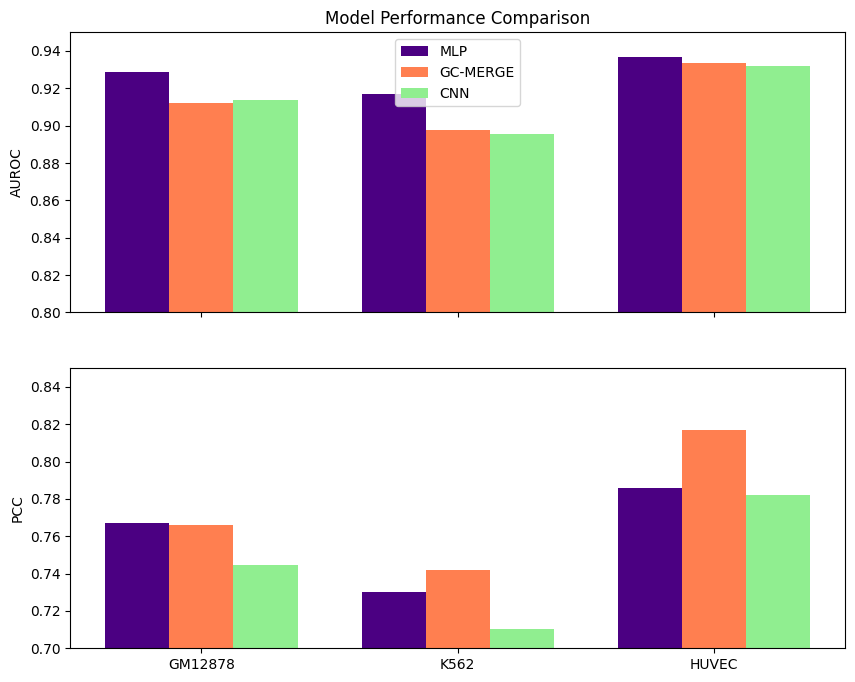

In [49]:
cell_line_names = ['GM12878', 'K562', 'HUVEC']
auroc_values = {
    'MLP': mlp_data['auroc'].values,          
    'GC-MERGE': classification_results_meta['Test AUROC'].values,
    'CNN': cnn_metrics['auroc'].values
}
pcc_values = {
    'MLP': mlp_data['pcc'].values,       
    'GC-MERGE': regression_results_meta['Test pearson'].values,
    'CNN': cnn_metrics['pcc'].values
}

x = np.arange(len(cell_line_names))
width = 0.25  

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# AUROC bars
ax1.bar(x - width, auroc_values['MLP'], width, label='MLP', color='indigo')
ax1.bar(x, auroc_values['GC-MERGE'], width, label='GC-MERGE', color='coral')
ax1.bar(x + width, auroc_values['CNN'], width, label='CNN', color='lightgreen')
ax1.set_ylabel('AUROC')
ax1.set_ylim(0.80, 0.95)
ax1.set_title('Model Performance Comparison')
ax1.legend()

# PCC bars
ax2.bar(x - width, pcc_values['MLP'], width, label='MLP', color='indigo')
ax2.bar(x, pcc_values['GC-MERGE'], width, label='GC-MERGE', color='coral')
ax2.bar(x + width, pcc_values['CNN'], width, label='CNN', color='lightgreen')
ax2.set_ylabel('PCC')
ax2.set_ylim(0.7, 0.85)
ax2.set_xticks(x)
ax2.set_xticklabels(cell_line_names)

plt.show()


In [41]:
gcn_results

{'E116': {'y_true': array([7.4816443e-02, 1.2221588e-01, 1.6026676e+00, ..., 8.6685643e-04,
         0.0000000e+00, 1.8273369e+00], dtype=float32),
  'y_pred': array([0.75512505, 1.2212895 , 0.5311072 , ..., 0.04765021, 0.05083667,
         1.1735519 ], dtype=float32)},
 'E122': {'y_true': array([0.39759243, 0.00216606, 0.        , ..., 0.        , 0.        ,
         0.5661386 ], dtype=float32),
  'y_pred': array([0.69241256, 0.2089414 , 0.0147909 , ..., 0.03534405, 0.0304466 ,
         1.4553151 ], dtype=float32)},
 'E123': {'y_true': array([1.6577536 , 0.87765944, 0.96736073, ..., 0.00302947, 1.339968  ,
         0.3170181 ], dtype=float32),
  'y_pred': array([1.3715566 , 1.096382  , 0.9502483 , ..., 0.38962704, 0.24517499,
         0.902174  ], dtype=float32)}}

In [45]:
gcn_results

{'E116': {'y_true': array([7.4816443e-02, 1.2221588e-01, 1.6026676e+00, ..., 8.6685643e-04,
         0.0000000e+00, 1.8273369e+00], dtype=float32),
  'y_pred': array([0.75512505, 1.2212895 , 0.5311072 , ..., 0.04765021, 0.05083667,
         1.1735519 ], dtype=float32)},
 'E122': {'y_true': array([0.39759243, 0.00216606, 0.        , ..., 0.        , 0.        ,
         0.5661386 ], dtype=float32),
  'y_pred': array([0.69241256, 0.2089414 , 0.0147909 , ..., 0.03534405, 0.0304466 ,
         1.4553151 ], dtype=float32)},
 'E123': {'y_true': array([1.6577536 , 0.87765944, 0.96736073, ..., 0.00302947, 1.339968  ,
         0.3170181 ], dtype=float32),
  'y_pred': array([1.3715566 , 1.096382  , 0.9502483 , ..., 0.38962704, 0.24517499,
         0.902174  ], dtype=float32)}}

In [47]:
cell_lines

['GM12878', 'K562', 'HUVEC']

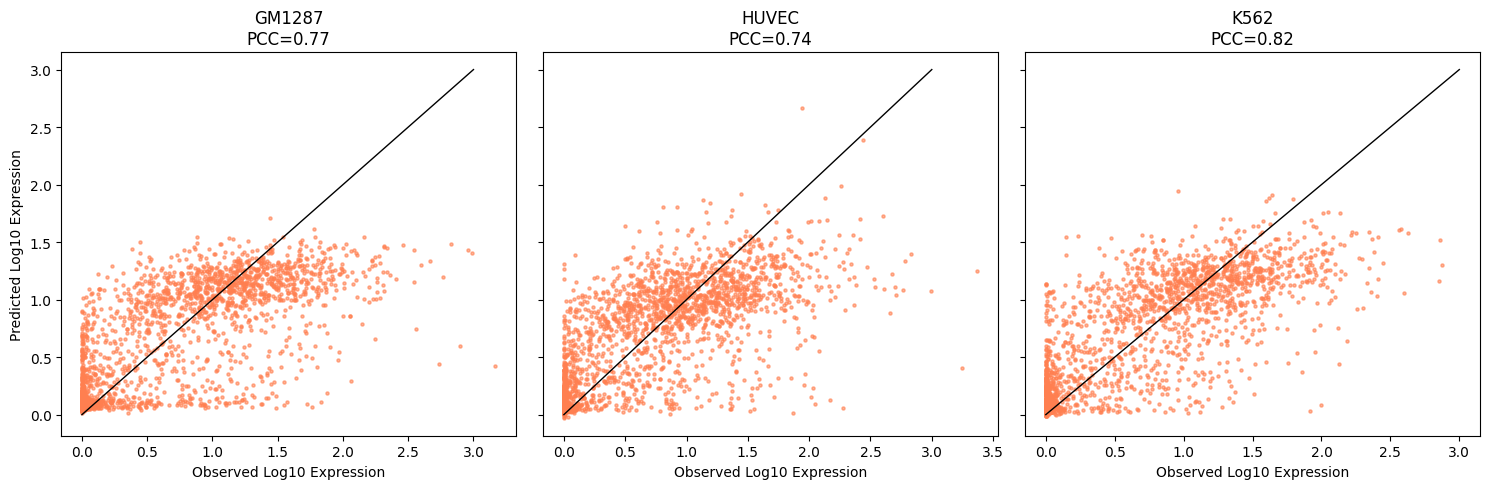

In [54]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, cell_line in enumerate(cell_lines):
    observed = gcn_results[cell_line]['y_true']
    predicted_gc_merge = gcn_results[cell_line]['y_pred']
    
    axs[i].scatter(observed, predicted_gc_merge, alpha=0.6, s=5, color='coral', label='GC-MERGE')
    axs[i].plot([0, 3], [0, 3], 'k-', lw=1)  
    axs[i].set_title(f'{cl_conversion_dct[cell_line]}\nPCC={pcc_values["GC-MERGE"][i]:.2f}')
    axs[i].set_xlabel('Observed Log10 Expression')
    if i == 0:
        axs[i].set_ylabel('Predicted Log10 Expression')

plt.tight_layout()
plt.show()


### Reference

Agarwal, V., & Shendure, J. (2020). Predicting mRNA abundance directly from genomic sequence using deep convolutional neural networks. *Cell Reports*, 31(7), 107663. [Link](https://doi.org/10.1016/j.celrep.2020.107663)

Bigness, J., Loinaz, X., Patel, S., Larschan, E., & Singh, R. (2022). Integrating long-range regulatory interactions to predict gene expression using graph convolutional networks. *Journal of Computational Biology*, 29(5), 485-499. [Link](https://doi.org/10.1089/cmb.2021.0316)

Singh, R., Lanchantin, J., Robins, G., & Qi, Y. (2016). DeepChrome: Deep-learning for predicting gene expression from histone modifications. *Bioinformatics*, 32(17), i639-i648. [Link](https://doi.org/10.1093/bioinformatics/btw427)